# Dealing with Low Confidence Situations

First we analyze a few scenarios where spurious examines or clicks result in inaccurate relevance grades. We then augment the SDBN judgments with a beta prior to better model the amount of confidence we have in the underlying click data.

In [1]:
from aips import *
import matplotlib.pyplot as plt
import numpy
from ltr.sdbn_functions import *
import aips.indexer
from aips import get_engine
aips.indexer.pull_github_repository("signals")
aips.indexer.build_collection(get_engine(), "products")

# if using a Jupyter notebook, includue:
%matplotlib inline

In [2]:
all_sessions()

,sess_id,query,rank,doc_id,clicked
0,50002,blue ray,0.0,600603141003,True
1,50002,blue ray,1.0,827396513927,False
2,50002,blue ray,2.0,24543672067,False
3,50002,blue ray,3.0,719192580374,False
4,50002,blue ray,4.0,885170033412,True
...,...,...,...,...,...
74995,5001,transformers dark of the moon,10.0,47875841369,False
74996,5001,transformers dark of the moon,11.0,97363560449,False
74997,5001,transformers dark of the moon,12.0,93624956037,False
74998,5001,transformers dark of the moon,13.0,97363532149,False


In [3]:
sessions = all_sessions()
products = fetch_products(doc_ids=sessions["doc_id"].unique())

def print_dataframe(dataframe):
    pandas.set_option("display.max_colwidth", 36)
    pandas.set_option("display.width", 120)
    merged = dataframe.merge(products[["upc", "name"]], left_on='doc_id', right_on='upc', how='left')
    print(merged.rename(columns={"upc": "doc_id"}).set_index("doc_id"))

## Listing 11.11

Computing relevance judgments for `blue ray` a simulated tail query that represents a misspelling with sparse data.

In [4]:
#%load -s caclulate_examine_probability,calculate_clicked_examined,calculate_grade ../ltr/sdbn_functions.py
def caclulate_examine_probability(sessions):
    last_click_per_session = sessions.groupby(["clicked", "sess_id"])["rank"].max()[True]
    sessions["last_click_rank"] = last_click_per_session
    sessions["examined"] = sessions["rank"] <= sessions["last_click_rank"]
    return sessions

def calculate_clicked_examined(sessions):
    sessions = caclulate_examine_probability(sessions)
    return sessions[sessions["examined"]] \
        .groupby("doc_id")[["clicked", "examined"]].sum()

def calculate_grade(sessions):
    sessions = calculate_clicked_examined(sessions)
    sessions["grade"] = sessions["clicked"] / sessions["examined"]
    return sessions.sort_values("grade", ascending=False)

def get_sample_sessions(query):
    sessions = get_sessions(query, index=False) 
    sessions = sessions[sessions["sess_id"] < 50050]
    return sessions.set_index("sess_id")

In [5]:
sessions = get_sample_sessions("blue ray")
grade_data = calculate_grade(sessions)
#print_dataframe(grade_data)
display(grade_data)

,clicked,examined,grade
doc_id,,,
600603132872,1,1,1.000000
827396513927,14,34,0.411765
25192073007,8,20,0.400000
885170033412,6,19,0.315789
600603141003,8,26,0.307692
24543672067,8,27,0.296296
813774010904,2,7,0.285714
883929140855,2,7,0.285714
22265052211,1,4,0.250000


# Figure 11.8

Beta distribution for grade=0.125

a=2.5 b=17.5


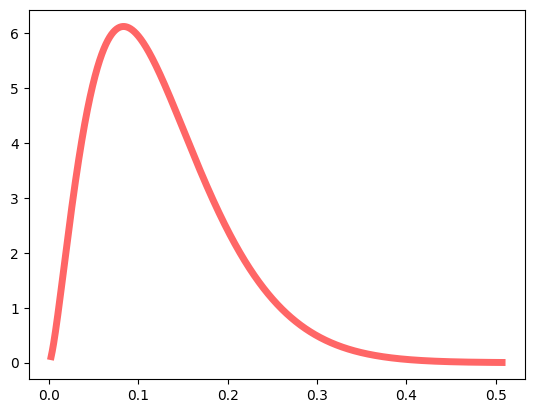

In [6]:
#Why is this rendering small?
from scipy.stats import beta

prior_grade = 0.125
prior_weight = 20
a = prior_grade * prior_weight; b = (1 - prior_grade) * prior_weight
print(f"a={a} b={b}")

x = numpy.linspace(beta.ppf(0.0001, a, b), beta.ppf(0.9999, a, b), 10000)
fig, ax = plt.subplots(1, 1)
ax.plot(x, beta.pdf(x, a, b), 'r-', lw=5, alpha=0.6, label='beta pdf')

# Figure 11.9

Adding clicks to the beta distribution

a=3.5 b=17.5


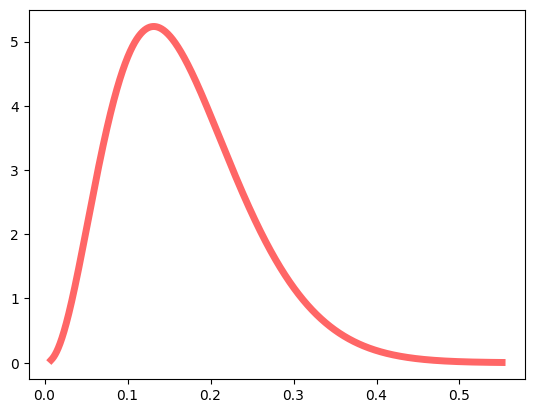

In [7]:
# Fit a beta prior to global_ctr
a += 1
print(f"a={a} b={b}")

x = numpy.linspace(beta.ppf(0.0001, a, b), beta.ppf(0.9999, a, b), 10000)
fig, ax = plt.subplots(1, 1)

ax.plot(x, beta.pdf(x, a, b),
        "r-", lw=5, alpha=0.6, label="beta pdf")

## Listing 11.12

Starting with a prior beta distribution for each document for "blue ray"

In [8]:
def calculate_prior(sessions, prior_grade, prior_weight):
  sessions = calculate_grade(sessions)
  sessions["prior_a"] = prior_grade * prior_weight
  sessions["prior_b"] = (1 - prior_grade) * prior_weight 
  return sessions

In [9]:
prior_grade = 0.3
prior_weight = 100
query = "blue ray"
sessions = get_sample_sessions(query)
prior_data = calculate_prior(sessions, prior_grade, prior_weight)
print(prior_data)

              clicked  examined     grade  prior_a  prior_b
doc_id                                                     
600603132872        1         1  1.000000     30.0     70.0
827396513927       14        34  0.411765     30.0     70.0
25192073007         8        20  0.400000     30.0     70.0
885170033412        6        19  0.315789     30.0     70.0
600603141003        8        26  0.307692     30.0     70.0
24543672067         8        27  0.296296     30.0     70.0
813774010904        2         7  0.285714     30.0     70.0
883929140855        2         7  0.285714     30.0     70.0
22265052211         1         4  0.250000     30.0     70.0
786936817232        2         8  0.250000     30.0     70.0
883929197965        2         9  0.222222     30.0     70.0
719192580374        4        18  0.222222     30.0     70.0
711719983156        2        10  0.200000     30.0     70.0
36725608443         1         6  0.166667     30.0     70.0
36725617605         1         8  0.12500

## Listing 11.13

Here we update the beta posterior to account for the observations in our data. We then compute a new grade, `beta-grade` from the posterior distribution.

In [10]:
#%load -s calculate_sdbn ../ltr/sdbn_functions.py
def calculate_sdbn(sessions, prior_grade=0.3, prior_weight=100):
    sessions = calculate_prior(sessions, prior_grade, prior_weight)
    sessions["posterior_a"] = (sessions["prior_a"] + 
                               sessions["clicked"])
    sessions["posterior_b"] = (sessions["prior_b"] + 
      sessions["examined"] - sessions["clicked"])
    sessions["beta_grade"] = (sessions["posterior_a"] /
      (sessions["posterior_a"] + sessions["posterior_b"]))
    return sessions.sort_values("beta_grade", ascending=False)

In [11]:
query = "blue ray"
sessions = get_sample_sessions(query)
bluray_sdbn_data = calculate_sdbn(sessions)
print(bluray_sdbn_data)

              clicked  examined     grade  prior_a  prior_b  posterior_a  \
doc_id                                                                     
827396513927       14        34  0.411765     30.0     70.0         44.0   
25192073007         8        20  0.400000     30.0     70.0         38.0   
600603132872        1         1  1.000000     30.0     70.0         31.0   
885170033412        6        19  0.315789     30.0     70.0         36.0   
600603141003        8        26  0.307692     30.0     70.0         38.0   
24543672067         8        27  0.296296     30.0     70.0         38.0   
813774010904        2         7  0.285714     30.0     70.0         32.0   
883929140855        2         7  0.285714     30.0     70.0         32.0   
22265052211         1         4  0.250000     30.0     70.0         31.0   
786936817232        2         8  0.250000     30.0     70.0         32.0   
883929197965        2         9  0.222222     30.0     70.0         32.0   
36725608443 

In [12]:
render_judged(products,
              bluray_sdbn_data,
              grade_col="beta_grade",
              label=f"SDBN judgments for q={query}")

,beta_grade,upc,image,name
0,0.3284,827396513927.0000,,Panasonic - Refurbished Wi-Fi Ready Blu-ray Disc Player
1,0.3167,25192073007.0000,,The Blues Brothers - Widescreen Dubbed Subtitle - Blu-ray Disc
2,0.3167,25192073007.0000,,Blues Brothers (Rated) (Unrated) - Widescreen Dubbed Subtitle - Blu-ray Disc
3,0.3069,NaN,NaN,NaN
4,0.3025,885170033412.0000,,Panasonic - Blu-ray Player


In [13]:
products[products["upc"] == 25192073007]

,image,upc,name,name_ngram,name_omit_norms,name_txt_en_split,manufacturer,short_description,long_description,id,_version_
294,"<img height=""100"" src=""../../data/retrotech/im...",25192073007,The Blues Brothers - Widescreen Dubbed Subtitl...,The Blues Brothers - Widescreen Dubbed Subtitl...,The Blues Brothers - Widescreen Dubbed Subtitl...,The Blues Brothers - Widescreen Dubbed Subtitl...,,,,2be731df-5f78-44ce-8b6f-f5017a7dde92,1810006029686013962
302,"<img height=""100"" src=""../../data/retrotech/im...",25192073007,Blues Brothers (Rated) (Unrated) - Widescreen ...,Blues Brothers (Rated) (Unrated) - Widescreen ...,Blues Brothers (Rated) (Unrated) - Widescreen ...,Blues Brothers (Rated) (Unrated) - Widescreen ...,,,,bb7c3573-b217-45d7-bf78-17111e6b6bec,1810006029653508104


# Figure 11.10 source code

Rendering beta distribution updated judgments to model our confidence in them

In [14]:
query = "dryer"
sessions = get_sessions(query)
dryer_sdbn = calculate_sdbn(sessions, 0.3, 100)

render_judged(products, 
              dryer_sdbn, 
              grade_col='beta_grade',
              label=f"Confidence Adjusted SDBN judgments for q={query}")

,beta_grade,upc,image,name
0,0.3853,856751002097,,Practecol - Dryer Balls (2-Pack)
1,0.3748,48231011396,,LG - 3.5 Cu. Ft. 7-Cycle High-Efficiency Washer - White
2,0.3158,84691226727,,GE - 6.0 Cu. Ft. 3-Cycle Electric Dryer - White
3,0.2946,74108007469,,Conair - 1875-Watt Folding Handle Hair Dryer - Blue
4,0.2775,12505525766,,Smart Choice - 6' 30 Amp 3-Prong Dryer Cord


# Figure 11.11 source code

Rendering beta distribution updated judgments to model our confidence in them

In [15]:
query = "transformers dark of the moon"
sessions = get_sessions(query)
transformers_sdbn = calculate_sdbn(sessions, 0.3, 100)

render_judged(products, 
              transformers_sdbn, 
              grade_col='beta_grade',
              label=f"Confidence Adjusted SDBN judgments for <br> q={query}")

,beta_grade,upc,image,name
0,0.5957,97360810042,,Transformers: Dark of the Moon - Blu-ray Disc
1,0.4017,400192926087,,Transformers: Dark of the Moon - Original Soundtrack - CD
2,0.3673,97363560449,,Transformers: Dark of the Moon - Widescreen Dubbed Subtitle - DVD
3,0.3130,97363532149,,Transformers: Revenge of the Fallen - Widescreen Dubbed Subtitle - DVD
4,0.2795,93624956037,,Transformers: Dark of the Moon - Original Soundtrack - CD


In [16]:
# %load -s product_search_request aips/search_requests
def product_search_request(query, param_overrides={}):
    request = {"query": query,
               "query_fields": ["name", "manufacturer", "long_description"],
               "return_fields": ["upc", "name", "manufacturer", "score"],
               "limit": 5,
               "order_by": [("score", "desc"), ("upc", "asc")]}
    return request | param_overrides

from aips import get_engine
query = "transformers dvd"
request = product_search_request(query)
response = get_engine().get_collection("products").search(**request)
display_product_search(query, response["docs"])

Up next: [Chapter 12: Overcoming Bias in Learned Relevance Models](../ch12/0.setup.ipynb)